# 3. Radial Basis Function Network Network

In [1]:
%matplotlib widget

In [2]:
import pickle
from copy import deepcopy
from multiprocessing import Pool
from pathlib import Path
from functools import partial

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange
from tqdm.contrib.itertools import product

from system_identification.utils.vdom import tabulate
from system_identification.rbfnn_model import RadialBasisFunctionNeuralNetworkModel
from system_identification.rbf_batch_trainer import RBFBatchTrainer, get_results

## Load data

In [3]:
data = xr.open_dataset("data/data_smoothed.nc")
data

<xarray.Dataset>
Dimensions:                 (t: 10001, dim_0: 4, dim_1: 4, x_idx: 4,
                             all_samples: 10001, inputs: 2, m: 1, outputs: 1,
                             training_samples: 7001, validation_samples: 3000,
                             d0: 2, d1: 2)
Coordinates:
  * t                       (t) float64 0.0 0.01 0.02 0.03 ... 99.98 99.99 100.0
Dimensions without coordinates: dim_0, dim_1, x_idx, all_samples, inputs, m,
                                outputs, training_samples, validation_samples,
                                d0, d1
Data variables: (12/42)
    p_k1k1                  (t, dim_0, dim_1) float64 ...
    p_kk1                   (t, dim_0, dim_1) float64 ...
    phi                     (t, dim_0, dim_1) float64 ...
    gamma                   (t, dim_0, dim_1) float64 ...
    ps                      (t, dim_0, dim_1) float64 ...
    x_k1k1                  (t, x_idx) float64 ...
    ...                      ...
    alpha_estimate          (t) float64 ...
    training_inputs         (training_samples, inputs, m) float64 ...
    training_outputs        (training_samples, outputs, m) float64 ...
    validation_inputs       (validation_samples, inputs, m) float64 ...
    validation_outputs      (validation_samples, outputs, m) float64 ...
    input_range             (d0, d1) float64 ...

## 3.1 Linear Regression
The reconstructed F-16 dataset is approximated using a RBFNN. The RBF centers are placed in a uniform grid along the input range and amplitudes are estimated using Ordinary Least Squares (OLS).

### Hyperparameter optimization
The number of RBF's and widths need to be selected. To do this the number of RBF's and width in the grid is varied and the combination with the smallest absolute mean residual is chosen. For this part of the assignment.

In [46]:
# Training results data cache
data_path = Path("data/3_1_hyperparam_optimization.pickle").absolute()

# Define batch trainer
trainer = RBFBatchTrainer(    
    input_range=data.input_range.values,
    inputs=data.training_inputs.values,
    reference_outputs=data.training_outputs.values,
    validation_inputs=data.validation_inputs.values,
    validation_outputs=data.validation_outputs.values,
    method="trainlsqr",
    n_repeat=10,

    grid_sizes=list(reversed(range(1, 30, 1))),
    width_ranges=[(k, k) for k in np.linspace(0.5, 20, 30)],

    verbosity=1,
    path=data_path
)

In [48]:
# Train and view results dataset
results = trainer.train_batch()
results

  0%|          | 8/8700 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                            (grid_size: 29, width_range_min: 30)
Coordinates:
  * grid_size                          (grid_size) int64 1 2 3 4 ... 26 27 28 29
  * width_range_min                    (width_range_min) float64 0.5 ... 20.0
Data variables:
    width_range_max                    (grid_size, width_range_min) float64 0...
    best_epoch                         (grid_size, width_range_min) float64 1...
    residual_training_mean_absolute    (grid_size, width_range_min) float64 0...
    residual_training_mean             (grid_size, width_range_min) float64 -...
    residual_training_jb               (grid_size, width_range_min) float64 1...
    residual_validation_mean_absolute  (grid_size, width_range_min) float64 0...
    residual_validation_mean           (grid_size, width_range_min) float64 -...
    residual_validation_jb             (grid_size, width_range_min) float64 1...

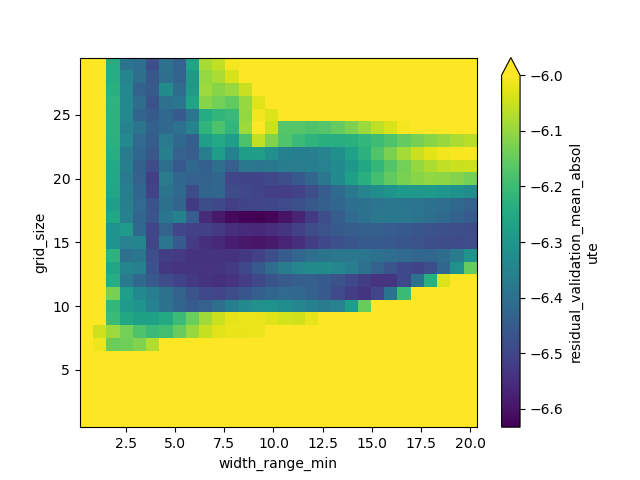

In [53]:
# Plot results
plt.figure()
np.log(results.residual_validation_mean_absolute).plot(vmax=-6)

In [54]:
# Find best configuration indexes
idxs = results.residual_validation_mean_absolute.argmin(...)
grid_size_idx = idxs['grid_size']
width_idx = idxs['width_range_min']

# Find best configurtion values
best_grid_size: int = results.grid_size[grid_size_idx].item()
best_width: float = results.width_range_min[width_idx].item()
best_residual_validation_mean_absolute: float = results.residual_validation_mean_absolute.isel(grid_size=grid_size_idx, width_range_min=width_idx)

# View results
tabulate({
    "best_grid_size": best_grid_size,
    "best_width": best_width,
    "error_validation_abs_mean": best_residual_validation_mean_absolute,
}, caption="Selected hyperparameters")

best_grid_size,17.0
best_width,9.241379310344827
error_validation_abs_mean,0.0013164458438025709


#### Selected configuration

In [55]:
# Create model with best values
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=2,
    grid_size=[best_grid_size, best_grid_size],
    input_range=data.input_range.values,
    width_range=(best_width, best_width),
    amplitude_range=(1, 1),
)

# Train model using OLS
model.train(
    inputs=data.training_inputs.values,
    reference_outputs=data.training_outputs.values,
    validation_inputs=data.validation_inputs.values,
    validation_outputs=data.validation_outputs.values,
    method="trainlsqr",
)

# Display results
tabulate(
    header=["Training data", "Validation data"],
    row_header=['Absolute residuals mean', "Jarque-Bera", "Jarque-Bera p-value"],
    data=[
        [abs(model.training_log.error_training_data).mean("i").item(),
         abs(model.training_log.error_validation_data).mean("j").item()],
        [model.training_log.error_training_jb.mean().item(),
         model.training_log.error_validation_jb.mean().item()],
        [model.training_log.error_training_jbp.mean().item(),
         model.training_log.error_validation_jbp.mean().item()]
    ]
)

,Training data,Validation data
Absolute residuals mean,0.0011861308019500694,0.0013164458438025709
Jarque-Bera,154.7876368134808,214.60551562036161
Jarque-Bera p-value,2.4450724516320835e-34,2.506134586001931e-47


## 3.2 Levenberg-Marquardt

The reconstructed F-16 dataset is approximated using a RBFNN. The RBF centers are initially placed in a uniform grid along the input range and the weights are given the same value as in the previous section.

The NN is then trained using the Levenberg-Marquardt (LM) learning algorithm to optimize the centers, widths and amplitudes.

### OLS best configuration
Training the best configuration to compare the convergence speed and residuals

In [ ]:
# Create model with best values from OLS
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=2,
    grid_size=[best_grid_size, best_grid_size],
    input_range=data.input_range.values,
    width_range=(best_width, best_width),
    amplitude_range=(1, 1),
)

# Train model using Levenberg-Marquardt
model.train(
    inputs=data.training_inputs.values,
    reference_outputs=data.training_outputs.values,
    validation_inputs=data.validation_inputs.values,
    validation_outputs=data.validation_outputs.values,
    epochs=500,
    goal=1e-6,
    train_log_freq=1,
    method="trainlm",
    mu=10.,
    alpha=0.995
)

# Get log of best epoch
best_epoch_idx = abs(model.training_log.error_validation_data).argmin(...)['epoch']
best_epoch_training_log = model.training_log.isel(epoch=best_epoch_idx)

# Display best epoch results
tabulate(
    header=["Training data", "Validation data"],
    row_header=['Absolute residuals mean', "Jarque-Bera", "Jarque-Bera p-value"],
    data=[
        [abs(best_epoch_training_log.error_training_data).mean().item(),
         abs(best_epoch_training_log.error_validation_data).mean().item()],
        [best_epoch_training_log.error_training_jb.item(),
         best_epoch_training_log.error_validation_jb.item()],
        [best_epoch_training_log.error_training_jbp.item(),
         best_epoch_training_log.error_validation_jbp.item()]
    ]
)

,Training data,Validation data
Absolute residuals mean,0.0014762124768357885,0.001530531493129597
Jarque-Bera,355.4962747011797,421.4482299717761
Jarque-Bera p-value,6.382117270899754e-78,3.045647644149336e-92


### OLS vs RBF initial condition sensitivity

In [18]:
# Reinitialize and train models n_samples times per batch, each batch is either:
#  1a. Initialized by placing the centers on a uniform grid
#  1b. Initialized by placing the centers using Loyds algorithm
#  2a. Trained using OLS
#  2b. Trained using LM
n_samples = 1000

# Training results data cache
data_path = Path("data/3_2_init_sensitivity.pickle").absolute()

# Define batch trainer
trainer = RBFBatchTrainer(    
    input_range=data.input_range.values,
    inputs=data.training_inputs.values,
    reference_outputs=data.training_outputs.values,
    validation_inputs=data.validation_inputs.values,
    validation_outputs=data.validation_outputs.values,
    grid_sizes=[17],
    width_ranges=[(1, 20)],
    amplitude_range=(0.5, 1.5),
    epochs=500,
    mu=10.,
    alpha=0.995,

    verbosity=1,
    path=data_path
)

In [20]:
results = trainer.run_init_sensitivity(n_samples)

  0%|          | 0/1000 [00:00<?, ?it/s]

/workspaces/system_identification/system_identification/rbfnn_model.py:509: RuntimeWarning: invalid value encountered in matmul
  delta_weights = np.linalg.inv(j.T @ j + mu * np.eye(j.shape[1])) @ j.T @ errors
/workspaces/system_identification/system_identification/rbfnn_model.py:509: RuntimeWarning: invalid value encountered in matmul
  delta_weights = np.linalg.inv(j.T @ j + mu * np.eye(j.shape[1])) @ j.T @ errors
/workspaces/system_identification/system_identification/rbfnn_model.py:509: RuntimeWarning: invalid value encountered in matmul
  delta_weights = np.linalg.inv(j.T @ j + mu * np.eye(j.shape[1])) @ j.T @ errors
/workspaces/system_identification/system_identification/rbfnn_model.py:509: RuntimeWarning: invalid value encountered in matmul
  delta_weights = np.linalg.inv(j.T @ j + mu * np.eye(j.shape[1])) @ j.T @ errors
/workspaces/system_identification/system_identification/rbfnn_model.py:509: RuntimeWarning: invalid value encountered in matmul
  delta_weights = np.linalg.inv(

<Axes: title={'center': 'residual_validation_mean'}, xlabel='[method, centers_init]'>

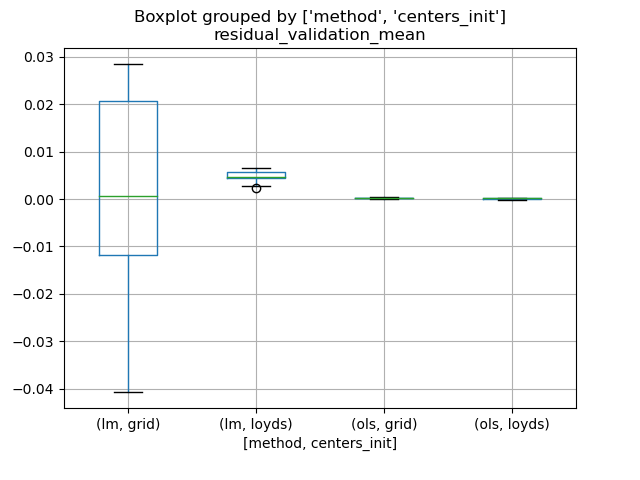

In [11]:
results.boxplot("residual_validation_mean", by=['method', 'centers_init'])